In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import uniform, norm
import seaborn as sns

# Bayesian Linear Regression Using MCMC Random Walk

The aim of this notebook is to estimate a linear regression parameter using mcmc random walk process. The result of the simulation will then be compared to parameter estimated using the frequentist approach, which is the OLS.

Set the experiment toy data

$$ y = ax+b+\epsilon $$
$\epsilon$ ~ N(0, $\sigma^{2}$)

There are 3 parameters that we want to estimate here: a, b, and $\epsilon$

In [46]:
np.random.seed(42)

In [47]:
x = np.linspace(10, 30)

# choose arbitrary number for the parameter
a = 5
b = 0
std = 5

e = np.random.normal(loc=0, scale=std, size=len(x))
y = (a*x)+b+e

#### Plot the toy samples

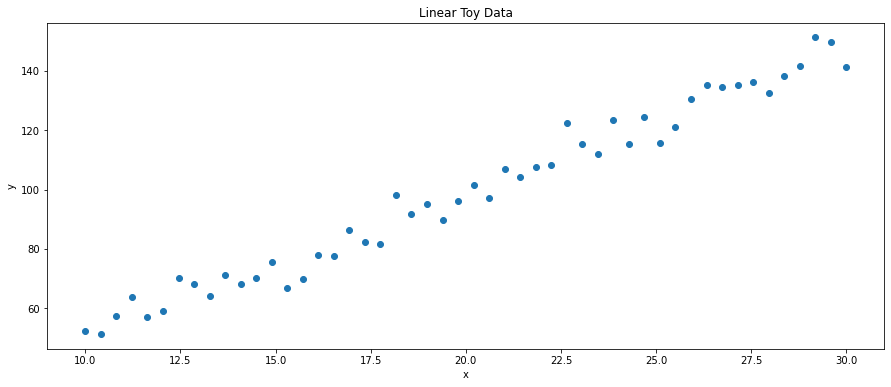

In [48]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y)
plt.title('Linear Toy Data')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

The first step would be to get the prior for each parameter. For simplicity, we will chose these 3 priors:
- a ~ U(0, 10)
- b ~ N(0, 25)
- std ~ U(0, 10)

Second step, set the transition probability distribution for each parameter $(q(\theta'|\theta))$. For simplicity, I choose to use normal distribution with the mean equal to previous iteration of a, b, and std, but arbitrary for the each of their standard deviation. 

Our Goal: P( a, b, std | D ), $D = (D_{1}, ..., D_{n})$, $D_{i} = (x_{i}, y_{i})$

Let $\pi$ be our target/goal distribution.

$$
\begin{align*}
\pi(a, b, std) = likelihood*prior 
= p(D|a, b, std)*p(a, b, std)
\end{align*}
$$


## Bayesian Linear Regression

### Code Setup

In [49]:
# Source: https://github.com/tirthajyoti/Stats-Maths-with-Python/blob/master/R_Functions.py

def dunif(x, minimum=0,maximum=1, log=False):
    """
    Calculates the point estimate of the uniform distribution
    """
    result = uniform.pdf(x=x,loc=minimum,scale=maximum-minimum)
    result = np.where(result==0, 1, result)
    if log:
        return np.log(result)
    else:
        return result
def dnorm(x,mean=0,sd =1, log=False):
    """
    Calculates the density of the Normal distribution
    """
    result = norm.pdf(x,loc=mean,scale=sd)
    result = np.where(result==0, 1, result)
    if log:
        return np.log(result)
    else:
        return result

In [50]:
def prior(params):
    a, b, sd = params
    aprior = dunif(a, minimum=0, maximum=10, log=True)
    bprior = dnorm(b, mean=0, sd=5, log=True)
    sdprior = dunif(sd, minimum=0, maximum=10, log=True)
    return aprior+bprior+sdprior

def likelihood(params, x, y):
    a, b, sd = params
    y_hat = a*x+b
    
    # the likelihood probability for each D given the parameter
    d_likelihood = dnorm(y, mean=y_hat, sd=sd, log=True)
    tot_likelihood = np.sum(d_likelihood)
    return tot_likelihood

# this is the pi
def posterior(params, x, y):
    return prior(params)+likelihood(params, x, y)

def proposal(params):
    # random std
    arr_std = np.array([0.1, 0.5, 0.3])
    return np.random.normal(loc=params, scale=arr_std, size=3)

def random_walk(starting_position, walking_steps, space, y):
    
    # to calculate the acceptance rate
    accept = 0
    
    # set the chain array first
    history_walk = np.zeros((walking_steps+1, 3))
    history_walk[0, :] = starting_position
    
    # iterate for every possible steps we have
    for step in range(1, walking_steps+1):
        proposed_step = proposal(history_walk[step-1, :])
        accept_proposed_step = np.exp(posterior(proposed_step, space, y)-posterior(history_walk[step-1, :], space, y))
        
        if accept_proposed_step==np.nan:
            accept_proposed_step = 0
        
        # random uniform; hence the name random walk
        random_acceptance_rate = np.random.uniform(size=1)
        
        # determine whether we should accept the proposed step or not using random uniform
        if accept_proposed_step>random_acceptance_rate:
            history_walk[step, :] = proposed_step
            accept += 1
        else:
            history_walk[step, :] = history_walk[step-1, :]
            
    return history_walk, accept/walking_steps


### Conduct Experiment

In [51]:
# set the seed first
initial_value = np.array([4, 0, 4])
steps = 10000
view_walk, acceptance_rate = random_walk(initial_value, steps, x, y)

In [52]:
view_walk

array([[ 4.        ,  0.        ,  4.        ],
       [ 4.        ,  0.        ,  4.        ],
       [ 4.06116763,  0.2910614 ,  4.26632454],
       ...,
       [ 4.9396705 , -0.49538469,  4.97585141],
       [ 4.9396705 , -0.49538469,  4.97585141],
       [ 4.9396705 , -0.49538469,  4.97585141]])

In [53]:
acceptance_rate

0.3018

0.3018 is a really good acceptance rate, as good acceptance rate is probably around 0.3 "Hejung Shim ~ Head lecturer in Melbourne University for Modern Applied Statistic"

### Result and Diagnostic Plot

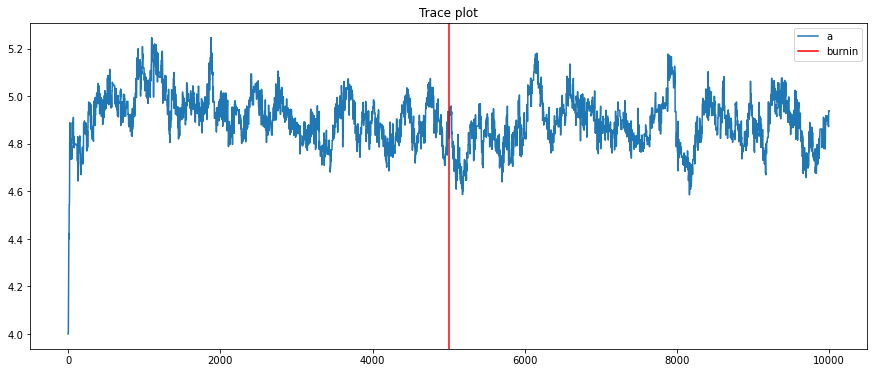

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(list(range(1, steps+2)), view_walk[:,0], label='a')
#plt.plot(list(range(1, steps+2)), view_walk[:,1], label='b')
#plt.plot(list(range(1, steps+2)), view_walk[:,2], label='std')
plt.axvline(x=5000, label='burnin', color='red')
plt.legend()
plt.title('Trace plot')
plt.show()

Try to uncomment the b and std diagnostic plot to see the result in each iteration. I plot this diagnostic trace plot to see the model's convergence behaviour. It can be seen that the model parameter is still quite volatile from this plot; hence, 10,000 iteration might not actually be enough for the parameter convergence result. However, to keep things simple, we will still continue using this result. We will also set a burn in of 5000, which is to discard the early 5000 result, and only keep the last 5000. The reason being is to exclude all parameter that is still in their early stage, as they may act as a noise rather than samples.

In [55]:
clean_view_walk = view_walk[5000:, :]

Plot each parameter result in histogram plot

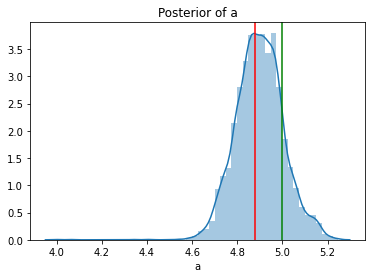

In [56]:
sns.distplot(view_walk[:, 0])
plt.title('Posterior of a')
plt.xlabel('a')
plt.axvline(x=np.mean(clean_view_walk[:, 0]), color='r', label='estimated value')
plt.axvline(x=a, color='g', label='ground truth value')
plt.show()

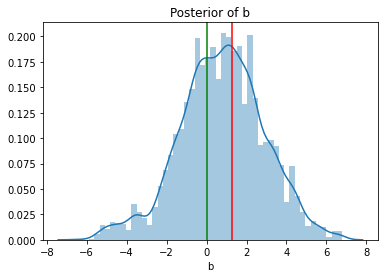

In [57]:
sns.distplot(view_walk[:, 1])
plt.title('Posterior of b')
plt.xlabel('b')
plt.axvline(x=np.mean(clean_view_walk[:, 1]), color='r', label='estimated value')
plt.axvline(x=b, color='g', label='ground truth value')
plt.show()

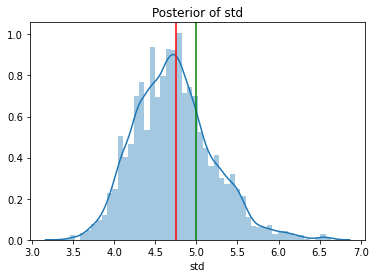

In [58]:
sns.distplot(view_walk[:, 2])
plt.title('Posterior of std')
plt.xlabel('std')
plt.axvline(x=np.mean(clean_view_walk[:, 2]), color='r', label='estimated value')
plt.axvline(x=std, color='g', label='ground truth value')
plt.show()

Instead of getting a point of estimate for each parameter, we get a distribution samples to approximate the parameter's distribution. For simplicity, we will use the mean as their point of estimate so that they are comparable to the OLS result.

The final result for our parameter estimate for the linear regression using the mean is as follow:
- a = 4.9
- b = 1.8
- std = 4.5

This result are actually quite far from the truth parameter; however, we are only using 10,000 iteration. Increasing the number of iteration and tuning the transition probability for each parameter may improve our estimate for each parameter.

### Compare with OLS result (frequentist approach)

In [59]:
X = sm.add_constant(x)
freq_model = sm.OLS(y, X)
res = freq_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1903.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           2.81e-40
Time:                        00:25:19   Log-Likelihood:                -146.61
No. Observations:                  50   AIC:                             297.2
Df Residuals:                      48   BIC:                             301.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7718      2.320      0.764      0.4

In [68]:
print('OLS Parameter Result: \n')
print(f'a: {res.params[0]}')
print(f'b: {res.params[1]}')
print(f'std: {np.sqrt(res.mse_resid)}')

OLS Parameter Result: 

a: 1.77180044831045
b: 4.855041501270444
std: 4.635522363339404


### Prediction Comparison 

In [73]:
OLS_res = res.predict(X)
Bay_res = 4.9*x+1.8

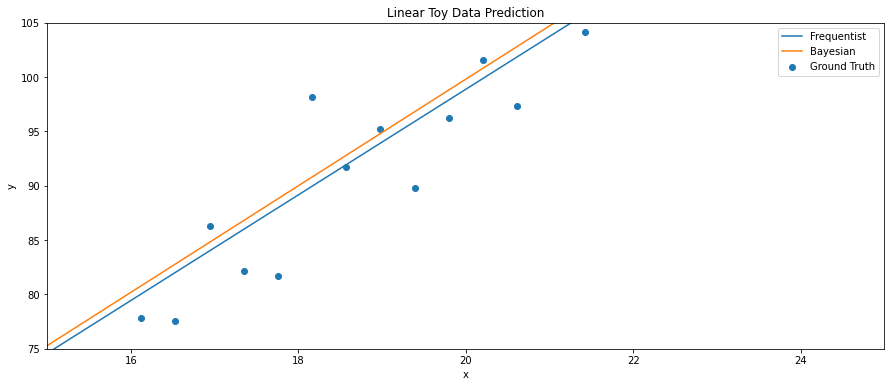

In [86]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y, label='Ground Truth')
plt.plot(x, OLS_res, label='Frequentist')
plt.plot(x, Bay_res, label='Bayesian')
plt.title('Linear Toy Data Prediction')
plt.ylabel('y')
plt.xlabel('x')
plt.xlim(15, 25)
plt.ylim(75, 105)
plt.legend()
plt.show()

As seen from the graph above, it seems that the result from bayesian and frequentist approach is pretty similar. There may not be a significant difference between both model's result. Thus, it seems that in this case, both method are fairly acceptable.

#### Credits:
- Heejung Shim "Head lecturer of Modern Applied Statistics ~ The University of Melbourne"
- Florian Hartig "Metropolis-Hastings example blog"